In [1]:
!pip install torch_geometric

Initial baseline update & reward

*   Read current labels from env_work.FrankenData.dist_label.
*   Convert labels to an action matrix with labels_to_action.

Call env_work.step(action_curr). This runs env.step


The returned reward_curr becomes the baseline reward for Metropolis comparisons. This also ensures env_work reflects the post-step opinions (so proposals are compared against a consistent oldX).

In [2]:
import numpy as np
import torch
from torch_geometric.data import Data
import gymnasium as gym
from gymnasium import spaces
import gerry_environment
from copy import deepcopy
from typing import Optional, Tuple, Dict, Any
import math
from graph_initiator import build_inchworm_init_data, build_inchworm_soc_init_data
# from render_graph import render_graph
import matplotlib.pyplot as plt
from report_gen_1 import summarize_results,pairwise_hamming_mean

In [3]:
def drf_inc_noso(discrepancy):
    delta = abs(discrepancy)

    if 0 == delta:
        return 0  # indifference

    elif 0 < delta < 3:
        return 1  # assimilation (pull closer)

    elif 3 <= delta < 10:
        return -1  # backfire (push away)

    elif 10 <= delta  :
        return 0  # irrelevance (ignored)

    elif delta == 0:
        return 0  # ambivalence

In [4]:
def labels_to_action(labels, num_districts, dtype=np.float32):
    """
    Convert an integer label vector (shape [N]) to an action matrix
    expected by env.step: shape (N, num_districts), each row is
    a 1-hot encoding of the desired district for that voter.
    """
    N = len(labels)
    A = np.zeros((N, num_districts), dtype=dtype)
    for i, lab in enumerate(labels):
        if lab >= 0 and lab < num_districts:
            A[i, int(lab)] = 1.0
        else:
            # keep row zeros -> will become -1 label in env.step (avoid if possible)
            pass
    return A

#**propose_flip**

The function implements a two-district cluster flip closely following the paper’s steps:

Choose a boundary/adjacent district pair (pick a cut edge).

Construct monochromatic internal edges for those two districts and optionally keep each internal edge with probability p_keep (this implements the Swendsen–Wang style random edge labeling).

Find the connected component (cluster) containing the chosen seed node u.

Flip that whole cluster to the other neighboring district.

Validate the proposed labels (no empty districts, contiguity) and reject if invalid

In [5]:
import numpy as np

def propose_flip(labels, geo_edge, rng, p_keep):
    """
    Propose a flip following the BFS-from-cut-edge style:
      1. pick random cut edge (u,v)
      2. grow a cluster in one district using BFS with kept mono edges
      3. flip cluster to the other district
      4. reject if it empties a district or breaks contiguity
    """
    N = len(labels)
    labels = labels.astype(int)

    # Step 1: collect cut edges (u,v where districts differ)
    diff_edges = [(int(u), int(v)) for u, v in geo_edge.T if labels[u] != labels[v]]

    if not diff_edges:
        return labels.copy()

    # pick random cut edge
    u, v = diff_edges[rng.integers(len(diff_edges))]
    dA, dB = labels[u], labels[v]

    # Step 2: build adjacency restricted to {dA,dB}, keep edges with prob p_keep
    adj = [[] for _ in range(N)]
    for x, y in geo_edge.T:
        if labels[x] == labels[y] and labels[x] in (dA, dB):
            if rng.random() < p_keep:
                adj[x].append(y)
                adj[y].append(x)

    # BFS cluster starting from u
    cluster = set()
    stack = [u]
    while stack:
        node = stack.pop()
        if node in cluster:
            continue
        cluster.add(node)
        stack.extend(adj[node])

    # Step 3: flip cluster to other district
    cluster_label = labels[u]
    target = dB if cluster_label == dA else dA
    new_labels = labels.copy()
    for node in cluster:
        new_labels[node] = target

    # Step 4a: non-empty check
    if not np.any(new_labels == dA) or not np.any(new_labels == dB):
        return labels.copy()

    # Step 4b: contiguity check
    def is_contiguous(lab):
        nodes = [i for i in range(N) if new_labels[i] == lab]
        if not nodes:
            return False
        seen = {nodes[0]}
        stack = [nodes[0]]
        while stack:
            n = stack.pop()
            for x, y in geo_edge.T:
                if x == n and new_labels[y] == lab and y not in seen:
                    seen.add(y); stack.append(y)
                elif y == n and new_labels[x] == lab and x not in seen:
                    seen.add(x); stack.append(x)
        return len(seen) == len(nodes)

    # only check districts that changed (source & target)
    if not is_contiguous(dA) or not is_contiguous(dB):
        return labels.copy()

    return new_labels


# **Main SA loop (hot → anneal → cold)**
For every SA iteration:

**1- Proposal generation (propose_flip):**
Chooses a border edge, builds a two-district cluster, flips it.
This is the proposal step.

**2- Pre-checks:**

Non-empty district check: all(np.any(y_prop == d) for d in ...). If a district would become empty, reject immediately.

Contiguity check: check_contiguity(geo_edge, y_prop, num_districts). If non-contiguous, reject immediately. This prevents expensive simulation for obviously invalid proposals.

**3- Evaluation (simulation):**

Convert y_prop into an action matrix with labels_to_action.

Make tmp_env = deepcopy(env_work) and call tmp_env.step(action_prop). That runs step and reward logic to produce reward_prop and tmp_env.FrankenData (the hypothetical post-proposal state).

This tmp_env.step is where the proposal is actually evaluated (it runs opinion update, elects reps, computes augmented graph and reward).

**4- Acceptance (Metropolis-style):**

Compute diff = reward_prop - reward_curr.
Acceptance probability p_accept = min(1, exp(diff / T)), where T is the current temperature (annealed linearly from T_init → T_final).

With probability p_accept accept the proposal: commit by setting env_work = tmp_env and reward_curr = reward_prop.

If rejected, env_work remains unchanged.

In [9]:
import numpy as np, math

def simulated_annealing(
    env,
    hot_steps,
    anneal_steps,
    cold_steps,
    T_init,
    T_final,
    seed,
    drf,
    beta1,
    beta2,
    p_keep
):
    rng = np.random.default_rng(seed)
    curr_labels = env.FrankenData.dist_label.clone().long().numpy().astype(int)

    if np.any(curr_labels < 0):
        raise ValueError("Current FrankenData.dist_label contains -1 (unassigned). Assign before SA.")

    # Baseline evaluation
    action_curr = labels_to_action(curr_labels, env.num_districts)
    current_obs, reward_curr, _, _, _ = env.step(action_curr, drf, beta1, beta2)

    ensemble_labels = [current_obs.dist_label]
    ensemble_rewards = [float(reward_curr)]
    # ensemble_opinion = [env.FrankenData.opinion.clone().long().numpy().astype(int).flatten()]
    ensemble_opinion = [current_obs.opinion]

    total_steps = hot_steps + anneal_steps + cold_steps
    step_idx = 0

    geo_edge = env.FrankenData.geographical_edge.clone().numpy()

    # Initialize acceptance tracking
    accepted = 0
    proposed = 0
    acceptance_history = []
    temperature_history = []

    # MAIN loop: hot -> anneal -> cold
    for phase, n_steps in (("hot", hot_steps), ("anneal", anneal_steps), ("cold", cold_steps)):
        for _ in range(n_steps):
            proposed += 1

            T = max(T_final, T_init + (T_final - T_init) * (step_idx / max(1, total_steps - 1)))
            temperature_history.append(T)
            step_idx += 1

            curr_labels = env.FrankenData.dist_label.clone().long().numpy().astype(int)
            y_prop = propose_flip(curr_labels, geo_edge, rng, p_keep)
            action_prop = labels_to_action(y_prop, env.num_districts)

            # Evaluate proposal
            obs_prop, reward_prop, _, _, _ = env.step(action_prop, drf, beta1, beta2)
            diff = float(reward_prop) - float(reward_curr)

            # Metropolis criterion
            try:
                p_accept = math.exp(diff / max(1e-8, T))
                p_accept = min(1.0, p_accept)
            except OverflowError:
                p_accept = 1.0 if diff > 0 else 0.0

            if rng.random() < p_accept:
                # accept
                accepted += 1
                reward_curr = float(reward_prop)
                ensemble_labels.append(y_prop)
                ensemble_rewards.append(reward_curr)
                ensemble_opinion.append(obs_prop.opinion)
            else:
                env.reset()

            # Record acceptance rate every few steps (optional)
            if proposed % 10 == 0:
                acc_rate = accepted / proposed
                acceptance_history.append(acc_rate)

    final_accept_rate = accepted / max(1, proposed)
    print(f"Total proposed: {proposed}, accepted: {accepted}, final acceptance rate: {final_accept_rate:.3f}")

    return env, ensemble_labels, ensemble_rewards, ensemble_opinion, acceptance_history, temperature_history


In [25]:
# ---- Setup initial data for inchworm without social edge ----
num_districts = 5

init_inch_data, G_inch = build_inchworm_init_data()

num_voters = init_inch_data.opinion.shape[0]
env = gerry_environment.FrankenmanderingEnv(num_voters=num_voters,
                          num_districts=num_districts,
                          FrankenData=init_inch_data,
                          target_opinion = [6,6,6,6,6,6,6,6,6,6],
                          opinion_dim = 1)
obs, _ = env.reset()
# fig = render_graph(obs)
# plt.show()


_, ensemble_labels, ensemble_rewards, ensemble_opinion, acc_hist, temp_hist = simulated_annealing(env,
    hot_steps=20,
    anneal_steps=40,
    cold_steps=20,
    T_init=1.0,
    T_final=0.01,
    seed=42,
    drf= drf_inc_noso,
    beta1 = 0.1,beta2=0.5,
    p_keep = 0.5)

ensemble_opinion = np.array([np.array(op).flatten() for op in ensemble_opinion])

print('---------------results with empty social graph----------------')
print("Final labels:", ensemble_labels)
print("Reward trajectory:", ensemble_rewards)
print("Opinion sequence:" , ensemble_opinion)

Total proposed: 80, accepted: 13, final acceptance rate: 0.163
---------------results with empty social graph----------------
Final labels: [tensor([1, 2, 0, 0, 4, 3, 3, 4, 4, 0]), array([1, 2, 0, 0, 0, 3, 3, 4, 4, 0]), array([1, 2, 0, 0, 4, 3, 4, 4, 4, 0]), array([1, 2, 4, 4, 4, 3, 3, 4, 4, 0]), array([1, 2, 0, 0, 0, 3, 3, 4, 0, 0]), array([1, 2, 4, 4, 4, 3, 3, 4, 4, 0]), array([1, 2, 0, 0, 0, 3, 3, 4, 0, 0]), array([1, 2, 0, 0, 0, 3, 3, 4, 0, 0]), array([1, 2, 0, 0, 4, 3, 4, 4, 4, 0]), array([1, 2, 4, 4, 4, 3, 3, 4, 4, 0]), array([1, 2, 4, 4, 4, 3, 3, 4, 4, 0]), array([1, 2, 0, 0, 0, 3, 3, 4, 0, 0]), array([1, 2, 0, 0, 0, 3, 3, 4, 0, 0]), array([1, 2, 4, 4, 4, 3, 3, 4, 4, 0])]
Reward trajectory: [-0.36142730712890625, -0.325714111328125, 0.6185722351074219, 2.6899986267089844, 2.7257156372070312, 2.6899986267089844, 2.7257156372070312, 2.7257156372070312, 0.6185722351074219, 2.6899986267089844, 2.6899986267089844, 2.7257156372070312, 2.7257156372070312, 2.6899986267089844]
Opinion se

=== MCMC Summary ===
Steps: 14
Reward mean = 1.973, std = 1.234
Reward range = [-0.361, 2.726], final = 2.690
Reward reached max at step 5

Final opinions mean = 2.800, std = 2.251, range = (0.0, 6.0)
Final labels: [1 2 4 4 4 3 3 4 4 0]
Label counts: {0: 1, 1: 1, 2: 1, 3: 2, 4: 5}



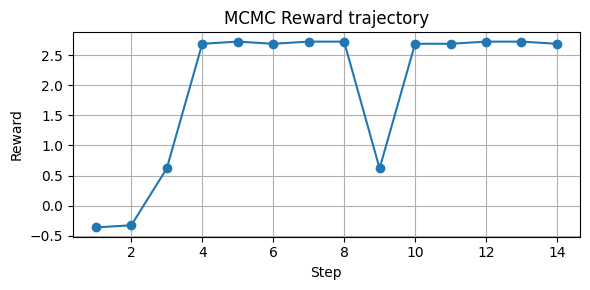

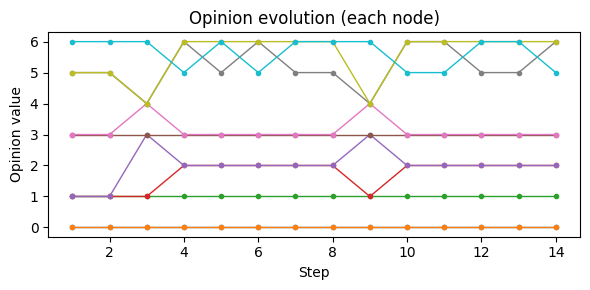

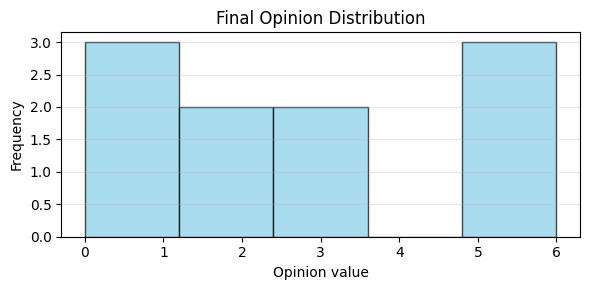

Final reward: 2.6899986267089844
Mean reward: 1.9734695979527064
Acceptance mean: 0.2340327380952381
{'steps': 14, 'reward_mean': 1.9734695979527064, 'reward_std': 1.2343145957666435, 'reward_min': -0.36142730712890625, 'reward_max': 2.7257156372070312, 'reward_final': 2.6899986267089844, 'reward_peak_step': 5, 'final_label_counts': {0: 1, 1: 1, 2: 1, 3: 2, 4: 5}, 'final_opinion_mean': 2.8, 'final_opinion_std': 2.250925735484551, 'final_opinion_range': (0.0, 6.0), 'final_labels': array([1, 2, 4, 4, 4, 3, 3, 4, 4, 0])}


In [26]:
summary_mcmc = summarize_results(ensemble_labels, ensemble_rewards, ensemble_opinion,acc_hist)
print(summary_mcmc)

=== MCMC Summary ===
Steps: 8
Reward mean = -0.862, std = 1.999
Reward range = [-2.361, 3.639], final = -1.361
Reward reached max at step 3

Final opinions mean = 3.300, std = 3.129, range = (1.0, 9.0)
Final labels: [1, 1, 2, 1, 3, 3, 4, 0, 0, 0]
Label counts: {0: 3, 1: 3, 2: 1, 3: 2, 4: 1}



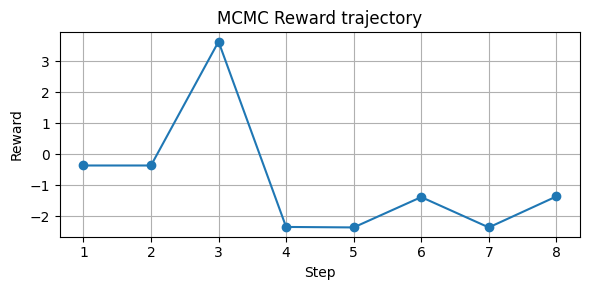

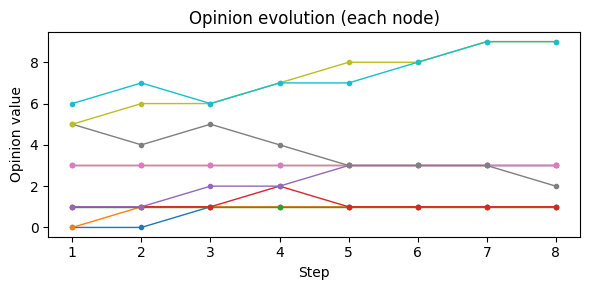

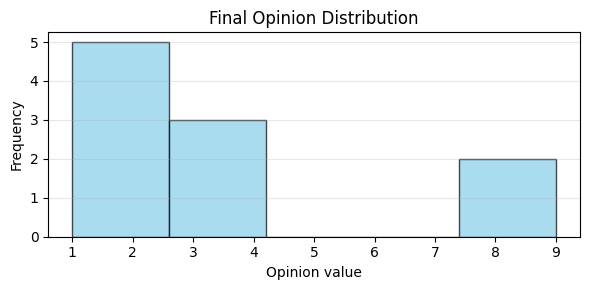

Final reward: -1.3614273071289062
Mean reward: -0.8619632720947266
Acceptance mean: 0.0
{'steps': 8, 'reward_mean': -0.8619632720947266, 'reward_std': 1.9990535922935477, 'reward_min': -2.3614273071289062, 'reward_max': 3.6385726928710938, 'reward_final': -1.3614273071289062, 'reward_peak_step': 3, 'final_label_counts': {0: 3, 1: 3, 2: 1, 3: 2, 4: 1}, 'final_opinion_mean': 3.3, 'final_opinion_std': 3.1287200080686173, 'final_opinion_range': (1.0, 9.0), 'final_labels': [1, 1, 2, 1, 3, 3, 4, 0, 0, 0]}


In [27]:
districts = [
   [1,2,0,0,4,3,3,4,4,0],
   [1,0,2,0,3,4,4,4,0,3],
   [0,1,2,0,3,3,3,0,4,4],
   [1,2,3,0,0,4,4,4,4,0],
   [2,1,1,1,0,0,4,4,0,3],
   [1,2,2,2,3,0,0,0,4,2],
   [1,1,2,1,3,4,0,0,0,3],
   [1,1,2,1,3,3,4,0,0,0]
]
opinion = [[0.0, 0.0, 1.0, 1.0, 1.0, 3.0, 3.0, 5.0, 5.0, 6.0],
 [0.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 4.0, 6.0, 7.0],
 [1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 5.0, 6.0, 6.0],
 [1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 7.0, 7.0],
 [1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 8.0, 7.0],
 [1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 8.0, 8.0],
 [1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 9.0, 9.0],
 [1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 2.0, 9.0, 9.0]]

rewards = [-0.36142730712890625,
 -0.36142730712890625,
 3.6385726928710938,
 -2.345714569091797,
 -2.3614273071289062,
 -1.3814277648925781,
 -2.3614273071289062,
 -1.3614273071289062]
summary_non_mcmc = summarize_results(districts, rewards, opinion, acc_hist=0)
print(summary_non_mcmc)


In [28]:
mean_r = np.mean(ensemble_rewards)
std_r  = np.std(ensemble_rewards)
print("Mean pairwise Hamming distance:", pairwise_hamming_mean(ensemble_labels))


Mean pairwise Hamming distance: 0.34505494505494494
